# Self-Driving Car Engineer Nanodegree
## Computer Vision
## Project: Vehicle Detection & Tracking

---
### Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import pickle
import cv2
import os
import shutil
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

---
### Load Training Images

In [2]:
# Read in cars and notcars images
cars = []
notcars = []

vehicle_images = glob.glob('./training_data/vehicles/*.png')
for image in vehicle_images:
    cars.append(image)
    
non_vehicle_images = glob.glob('./training_data/non_vehicles/*.png')
for image in non_vehicle_images:
    notcars.append(image)

### Visualize Training Images

Total number of car training images: 8792
Total number of non-car training images: 8968


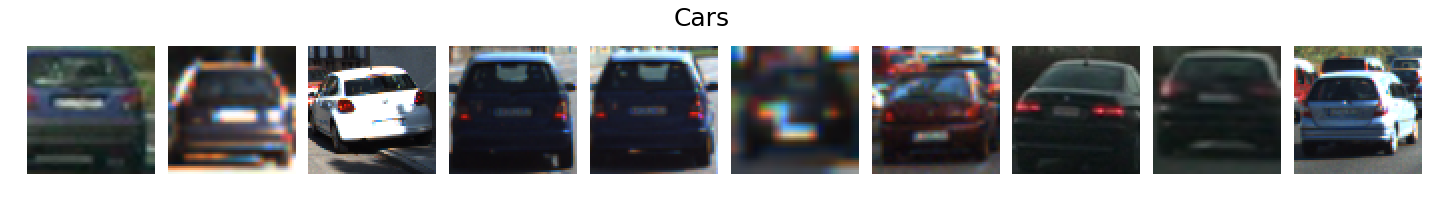

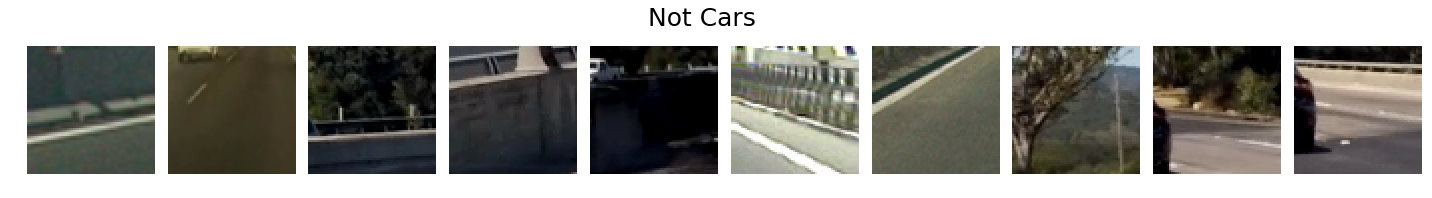

In [3]:
print('Total number of car training images: {}'.format(len(cars)))
print('Total number of non-car training images: {}'.format(len(notcars)))

# Visualize sample car images
fig = plt.figure(figsize=(25, 3))
fig.subplots_adjust(hspace = .000001, wspace = 0.1)
plt.suptitle('Cars', fontsize=25)
for i in range(0,10):
    plt.subplot(1, 10, i+1)
    plt.imshow(mpimg.imread(cars[np.random.randint(0,len(cars))]))
    plt.axis('off')
plt.show()

# Visualize sample non-car images
fig = plt.figure(figsize=(25, 3))
fig.subplots_adjust(hspace = .000001, wspace = 0.1)
plt.suptitle('Not Cars', fontsize=25)
for i in range(0,10):
    plt.subplot(1, 10, i+1)
    plt.imshow(mpimg.imread(notcars[np.random.randint(0,len(notcars))]))
    plt.axis('off')
plt.show()

---
### Parameters

In [4]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL" 
spatial_size = (32, 32) # Spatial binning dimensions 
hist_bins = 32 # Number of histogram bins 
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

---
### Feature Extraction

In [5]:
# Functions for extracting features

def convert_color(img, color_space='YCrCb'):     
    '''
    Converts image from RGB to other colorspaces
    '''
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        img = np.copy(img) 
    return img

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Returns HOG features and visualization.
    '''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    '''
    Computes binned color features.  
    '''
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    
    '''
    Computes color histogram features. 
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    A function to extract features from a list of images.
    Calls the get_hog_features(), color_hist() & bin_spatial functions.
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if colorspace other than 'RGB'
        feature_image = convert_color(image, color_space=color_space)     

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=True)
                hog_features = np.ravel(hog_features)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features)) # same as calling np.vstack() as np.concatenate() has default of 0
    # Return list of feature vectors
    return features  

### Visualize HOG Features

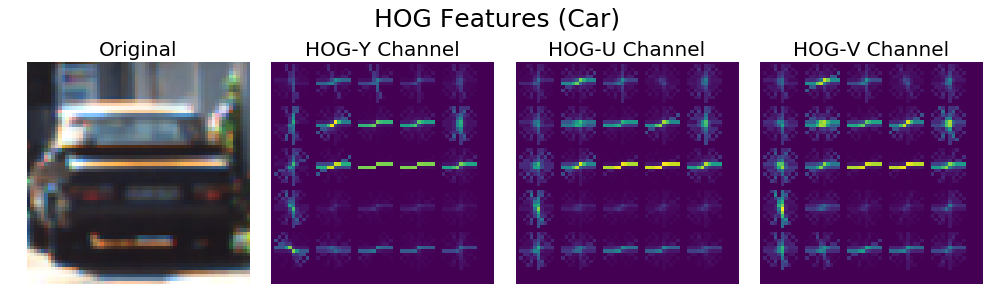

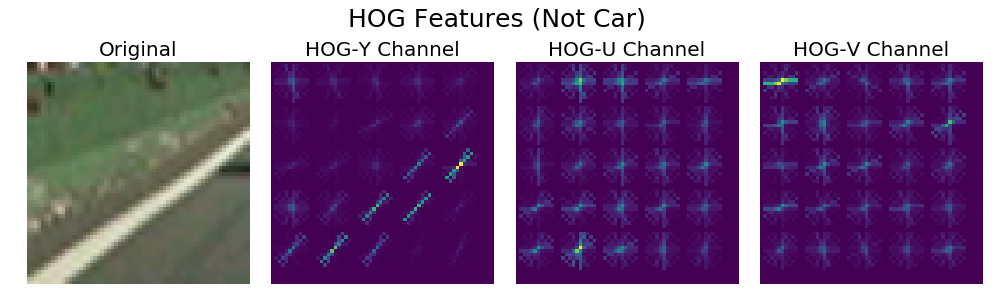

In [6]:
img = mpimg.imread(cars[np.random.randint(0,len(cars))])
yuv_img = convert_color(img, color_space='YUV')
_, hog_img_y = get_hog_features(yuv_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
_, hog_img_u = get_hog_features(yuv_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
_, hog_img_v = get_hog_features(yuv_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 5))
fig.tight_layout()
fig.subplots_adjust(hspace = .000001, wspace = 0.1)
plt.suptitle('HOG Features (Car)', fontsize=25)

ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax1.axis('off')

ax2.imshow(hog_img_y)
ax2.set_title('HOG-Y Channel', fontsize=20)
ax2.axis('off')

ax3.imshow(hog_img_u)
ax3.set_title('HOG-U Channel', fontsize=20)
ax3.axis('off')

ax4.imshow(hog_img_v)
ax4.set_title('HOG-V Channel', fontsize=20)
ax4.axis('off')

plt.show()

img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
yuv_img = convert_color(img, color_space='YUV')
_, hog_img_y = get_hog_features(yuv_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
_, hog_img_u = get_hog_features(yuv_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
_, hog_img_v = get_hog_features(yuv_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 5))
fig.tight_layout()
fig.subplots_adjust(hspace = .000001, wspace = 0.1)
plt.suptitle('HOG Features (Not Car)', fontsize=25)

ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax1.axis('off')

ax2.imshow(hog_img_y)
ax2.set_title('HOG-Y Channel', fontsize=20)
ax2.axis('off')

ax3.imshow(hog_img_u)
ax3.set_title('HOG-U Channel', fontsize=20)
ax3.axis('off')

ax4.imshow(hog_img_v)
ax4.set_title('HOG-V Channel', fontsize=20)
ax4.axis('off')

plt.show()

---
### Model Training

In [7]:
t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print('Feature extraction for complete training data set took {} seconds...\n'.format(round(t2-t, 2)))

X = np.vstack((car_features, notcar_features)).astype(np.float64)  
print('Total examples: {}\n'.format(len(X)))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using: {} orientations, {} pixels per cell and {} cells per block\n'.format(orient, pix_per_cell, cell_per_block))
print('Number of examples used for training: {}\n'.format(X_train.shape[0]))
print('Number of examples set-aside for testing: {}\n'.format(X_test.shape[0]))
print('Feature vector length: {}\n'.format(X_train.shape[1]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('Training SVC took {} seconds...\n'.format(round(t2-t, 2)))

# Check the score of the SVC
print('Test accuracy of SVC: {}\n'.format(round(svc.score(X_test, y_test), 4)))

Feature extraction for complete training data set took 287.36 seconds...

Total examples: 17760

Using: 11 orientations, 12 pixels per cell and 2 cells per block

Number of examples used for training: 14208

Number of examples set-aside for testing: 3552

Feature vector length: 2112

Training SVC took 18.72 seconds...

Test accuracy of SVC: 0.9727



### Model Parameter Tuning

**Training Comparison**

|Color|Spatial Bin.|Color Hist.|HOG Channels|HOG Orient.|HOG Pix./Cell|HOG Cells/Block|Feature Extrac. Time|Train. Time|Accuracy|
|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|HLS|Yes|Yes|All|9|8|2|401.06|15.88|0.9913|
|HLS|No|No|All|9|8|2|372.04|64.46|0.9783|
|HSV|No|No|All|9|8|2|377.77|16.67|0.9783|
|LUV|No|No|All|9|8|2|377.46|63.22|0.9772|
|YCrCb|No|No|All|9|8|2|377.22|56.81|0.9823|
|RGB|No|No|All|9|8|2|379.24|75.35|0.9679|
|YUV|No|No|All|9|8|2|379.22|55.97|0.9764|
|YUV|No|No|All|11|16|2|271.28|9.09|0.9733|
|YUV|No|No|All|11|12|2|285.50|18.55|0.9764|
*All times in seconds*

**Video Processing Comparison**

|Color|HOG Channels|HOG Orient.|HOG Pix./Cell|HOG Cells/Block|Video Frames|Processing Time|
|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|YUV|All|12|8|2|100|11|
|YUV|All|11|16|2|100|4.04|
|YUV|All|11|12|2|100|6.04|
*All times in minutes*

### Save Trained Model & Parameters

In [8]:
model_directory = './saved_model/'
model_file_name = 'svc.pickle'
model_full_path = os.path.join(model_directory, model_file_name)

if not os.path.exists(model_directory):
    os.makedirs(model_directory)  

if os.path.isfile(model_full_path):
    os.remove(model_full_path)
    
t = time.time()
if not os.path.isfile(model_full_path):
    print('Saving fitted model to pickle file...\n')
    try:
        with open(model_full_path, 'wb') as pfile:
            pickle.dump(
                {
                    'svc': svc,
                    'X_scaler': X_scaler,
                    'orient': orient,
                    'pix_per_cell': pix_per_cell,
                    'cell_per_block': cell_per_block,
                    'spatial_size': spatial_size,
                    'hist_bins': hist_bins,
                    'spatial_feat': spatial_feat,
                    'hist_feat': hist_feat,
                    'hog_feat': hog_feat,
                    'hog_channel': hog_channel,
                    'color_space':color_space
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save fitted model to {}!!!, Exception : {}\n'.format(model_full_path,e))
        raise
t2 = time.time()
print('Fitted model & params saved in pickle file successfully!!! Time taken {} seconds.'.format(round(t2-t, 2)))

Saving fitted model to pickle file...

Fitted model & params saved in pickle file successfully!!! Time taken 0.01 seconds.


---
### Load Trained Model & Parameters

In [9]:
model_directory = './saved_model/'
model_file_name = 'svc.pickle'
model_full_path = os.path.join(model_directory, model_file_name)
svc = None
X_scaler = None
color_space = None
orient = None
pix_per_cell = None
cell_per_block = None
hog_channel = None
spatial_size = None
hist_bins = None
spatial_feat = None
hist_feat = None
hog_feat = None

def load_model_and_params():
    global svc
    global X_scaler
    global color_space
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    global spatial_size
    global hist_bins
    global spatial_feat
    global hist_feat
    global hog_feat
    t = time.time()  
    with open(model_full_path, 'rb') as f:
        pickle_data = pickle.load(f)
        svc = pickle_data["svc"]
        X_scaler = pickle_data["X_scaler"]
        orient = pickle_data["orient"]
        pix_per_cell = pickle_data["pix_per_cell"]
        cell_per_block = pickle_data["cell_per_block"]
        spatial_size = pickle_data["spatial_size"]
        hist_bins = pickle_data["hist_bins"]
        spatial_feat = pickle_data['spatial_feat']
        hist_feat = pickle_data['hist_feat']
        hog_feat = pickle_data['hog_feat']
        hog_channel = pickle_data['hog_channel']
        color_space = pickle_data['color_space']

        del pickle_data  # Free up memory
    t2 = time.time()
    print('Fitted model & params loaded from pickle file successfully!!!Time taken {} seconds.\n'.format(round(t2-t, 2)))
    print('Parameters:\n')
    print('HOG features:{}\nHOG Orientation:{}\nHOG Pixels per cells:{}\nHOG cells per block:{}\nHOG channels:{}\nColorspace:{}\nSpatial features:{}\nSpatial size:{}\nHistogram features:{}\nHistogram bins:{}'.format(hog_feat,orient,pix_per_cell,cell_per_block,hog_channel,color_space,spatial_feat,spatial_size,hist_feat,hist_bins))

load_model_and_params() 

Fitted model & params loaded from pickle file successfully!!!Time taken 0.0 seconds.

Parameters:

HOG features:True
HOG Orientation:11
HOG Pixels per cells:12
HOG cells per block:2
HOG channels:ALL
Colorspace:YUV
Spatial features:False
Spatial size:(32, 32)
Histogram features:False
Histogram bins:32


---
### Car Detection

In [10]:
# Functions for detecting cars, creating a heatmap, thresholding & drawing cars' bounding boxes

def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
              hog_channel, color_space, spatial_feat=True, hist_feat=True, 
              ydims_scales=[(400,656,1)], x_threshold = 0, debug=False):
    '''
    A single function that extracts features using:
    hog sub-sampling, color histogram & spatial binning
    and detects cars.
    '''
    b_boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 # for JPEG images as mpimg.imread() reads in on a scale of 0-255 but PNG scale is 0-1
      
    for ydim_scale in ydims_scales:
        log_file.write('Scale: {}\n'.format(ydim_scale[2]))
        log_file.write('Y dimensions: {}-{}\n'.format(ydim_scale[0], ydim_scale[1]))
        img_tosearch = img[ydim_scale[0]:ydim_scale[1], :, :]
        log_file.write('Image size: {}\n'.format(img_tosearch.shape))
        ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
        if ydim_scale[2] != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/ydim_scale[2]), np.int(imshape[0]/ydim_scale[2]))) 
        log_file.write('Resized image size: {}\n'.format(ctrans_tosearch.shape))

        ch1 = ctrans_tosearch[:,:,0]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        
        # Instead of overlap, define how many cells to step
        # Change size dynamically based on scale range to cover more area, else right side is not covered completely
        cells_per_step = 2
        if (ydim_scale[2] > 2):
            cells_per_step = 1
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        hog1 = None    
        hog2 = None
        hog3 = None
        hog_c = None

        # Get HOG features for the entire image only once
        if hog_channel == 'ALL':
            for channel in range(ctrans_tosearch.shape[2]):
                # Compute individual channel HOG features for the entire image
                hog1 = get_hog_features(ctrans_tosearch[:,:,channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
                hog2 = get_hog_features(ctrans_tosearch[:,:,channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
                hog3 = get_hog_features(ctrans_tosearch[:,:,channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
        else:
                hog_c = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract HOG for this patch
                hog_features = None
                if hog_channel == 'ALL':
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) # 1
                else:
                    hog_features = hog_c[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get spatial features
                spatial_features = bin_spatial(subimg, size=spatial_size) # 2
                # Get color features
                hist_features = color_hist(subimg, nbins=hist_bins) # 3
                #log_file.write('spatial_features:{}, hist_features:{}, hog_features:{}\n'.format(spatial_features.shape, hist_features.shape, hog_features.shape))          
                all_features = None
                # Combine features
                if (spatial_feat and hist_feat):
                    all_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                elif (spatial_feat):    
                    all_features = np.hstack((spatial_features, hog_features)).reshape(1, -1)   
                elif (hist_feat):    
                    all_features = np.hstack((hist_features, hog_features)).reshape(1, -1)
                else:
                    all_features = hog_features.reshape(1, -1)

                # Scale features
                scaled_features = X_scaler.transform(all_features)    

                # Make prediction
                current_prediction = svc.predict(scaled_features)
                
                if (current_prediction == 1) or (debug):                                    
                    xbox_left = np.int(xleft*ydim_scale[2])
                    ytop_draw = np.int(ytop*ydim_scale[2])
                    win_draw = np.int(window*ydim_scale[2])
                        
                    x1 = xbox_left
                    y1 = ytop_draw+ydim_scale[0]
                    x2 = xbox_left+win_draw
                    y2 = ytop_draw+win_draw+ydim_scale[0]

                    if (debug and debug_full):
                        bbox_color_debug = (np.random.randint(50,225),np.random.randint(50,225),np.random.randint(50,225))
                        cv2.rectangle(draw_img, (x1,y1), (x2,y2), bbox_color_debug, 2)
                    
                    # Draw a rectanlge if: 
                    # (correctly predicted) and (prediction confidence > threshold) and (top-left x > threshold)
                    if (current_prediction == 1 and
                        svc.decision_function(scaled_features) > min_prediction_confidence and
                        x1 > x_threshold):
                        b_boxes.append(((x1, y1), (x2, y2)))                   
                        bbox_color_predict = (0,255,0)
                        cv2.rectangle(draw_img, (x1,y1), (x2,y2), bbox_color_predict, 3) 
                        log_file.write('Prediction confidence: {}\n'.format(svc.decision_function(scaled_features)))
                        log_file.write('Bounding box top-left: {}, bottom-right: {}\n'.format(str(x1)+','+str(y1),str(x2)+','+str(y2)))
                
    # Return the updated image & the bounding boxes
    return draw_img, b_boxes

def add_heat(heatmap, bbox_list):
    '''
    Creates a heatmap image.
    '''
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    '''
    Applies a threshold to the heatmap image.
    '''
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, min_bbox_w_h):
    '''
    Finds which pixels belong to a car & then draws a bounding box.
    Excludes those bounding boxes whose size is less than the provided threshold size.
    '''
    b_boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_w = bbox[1][0] - bbox[0][0]
        bbox_h = bbox[1][1] - bbox[0][1]
        if (bbox_w >= min_bbox_w_h[0] and bbox_h >= min_bbox_w_h[1]):          
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 3)
            b_boxes.append(bbox)
            log_file.write('Car: {} found with dimensions: {}x{}\n'.format(car_number, bbox_w, bbox_h))
        else:
            log_file.write('Car: {} with dimensions: {}x{} and bounding box: {} excluded as size less than threshold {}\n'.format(car_number, bbox_w, bbox_h, bbox, min_bbox_w_h))
    # Return the image & bounding boxes
    return img, b_boxes

---
### Heatmap Class

In [11]:
class HeatMap():
    '''
    A class for keeping track of previous 15 heatmaps & calculating an average heatmap from these heatmaps.
    '''
    def __init__(self):
        nan_img = np.full((720,1280),np.nan)
        self.heatmap_arr = deque(np.array([nan_img, nan_img, nan_img, nan_img, nan_img, 
                                           nan_img, nan_img, nan_img, nan_img, nan_img,
                                           nan_img, nan_img, nan_img, nan_img, nan_img]))
        self.heatmap_avg = np.nan
        
    def update(self, heatmap):
        self.heatmap_arr.popleft()
        self.heatmap_arr.append(heatmap)
        self.heatmap_avg = np.nanmean(self.heatmap_arr, axis=0)

---
### Main Pipeline 

In [12]:
def process_frame(frame):
    '''
    Main pipeline function for processing video frames.
    Writes useful messages to a log file. 
    Also draws bounding boxes & heatmaps at various stages of pipeline if debug is on.
    '''
    global frame_name
    global duplicate_threshold
    global ydims_scales
    global min_bbox_w_h
    global x_threshold
    global debug
    global frame_counter
    global use_avg_heatmap
    if (frame_name is None):
        frame_counter += 1
        frame_name = str(frame_counter) + '.jpg'  
    img = frame.copy()
    out_img = frame.copy()
    log_file.write('Processing frame: {}\n'.format(frame_name))
    
    t = time.time()
    out_img, b_boxes = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                                 spatial_size, hist_bins, hog_channel, color_space, 
                                 spatial_feat, hist_feat, ydims_scales=ydims_scales, 
                                 x_threshold = x_threshold, debug=debug)
    t2 = time.time()
    log_file.write('Detection took {} seconds...\n'.format(round(t2-t, 2)))
    if (debug):
        plt.figure(figsize=(15,10))
        plt.imshow(out_img)
        scales_used = [x[2] for x in ydims_scales]
        plt.title('Positive Detections - Scales: {}'.format(scales_used), fontsize=20)
        plt.yticks(np.arange(0, 721, 24))
        plt.show() 
    log_file.write('Total bounding boxes returned by find_cars(): {}\n'.format(len(b_boxes)))
        
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, b_boxes)
    
    if use_avg_heatmap:
        # Add to the heatmap queue
        heatmap_obj.update(heat)
        # Get averaged heatmap
        heat = heatmap_obj.heatmap_avg
    
    if (debug):
        plt.figure(figsize=(15,10))
        plt.imshow(heat, cmap='hot')
        title = 'Heatmap'
        if use_avg_heatmap:
            title = 'Averaged ' + title
        plt.title(title, fontsize=20)
        plt.show()

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, duplicate_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    if (debug):
        plt.figure(figsize=(15,10))
        plt.imshow(heatmap, cmap='hot')
        plt.title('Thresholded Heatmap', fontsize=20)
        plt.show() 

    # Call scipy.ndimage.measurements.label() function to find out how many cars have been found
    labels = label(heatmap)
    log_file.write('{} cars found!!!\n'.format(labels[1]))
    if (debug):
        plt.figure(figsize=(15,10))
        plt.imshow(heatmap, cmap='gray')
        plt.title('Labels', fontsize=20)
        plt.show()
    
    # Find final bounding boxes from the labeled heatmap
    draw_img, b_boxes = draw_labeled_bboxes(np.copy(frame), labels, min_bbox_w_h)
  
    log_file.write('-'*125 + '\n')
    return draw_img

---
### Sliding Window Scales

|Scale|Size (wxh)|Overlap % (x & y)|Window Step (pixels)|No. of Windows (vertically)|Start (y-axis)|End (y-axis)|
|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|1.0|64x64|62.50|24|3|400|536|
|1.3|83x83|62.74|31|3|400|578|
|1.5|96x96|62.50|36|3|400|604|
|1.7|108x108|63.23|40|3|400|630|
|2.0|128x128|62.50|48|3|400|672|
|2.5|160x160|81.25|30|4|400|680|
|3.0|192x192|81.25|36|2|400|664|
|3.5|224x224|81.25|42|2|400|708|

---
### Pipeline Run on Test Image

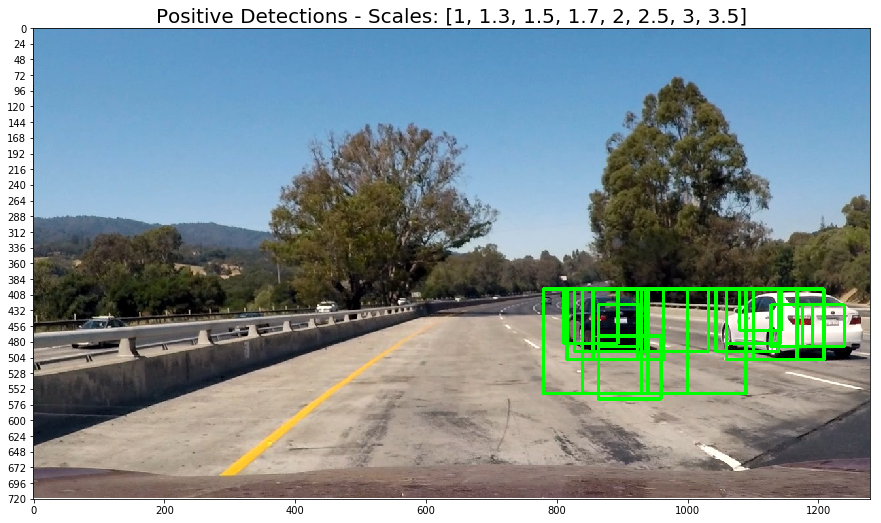

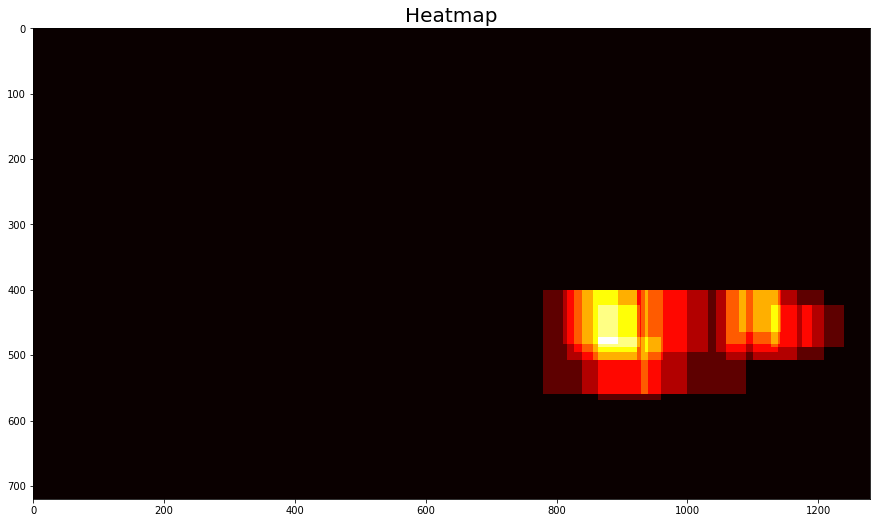

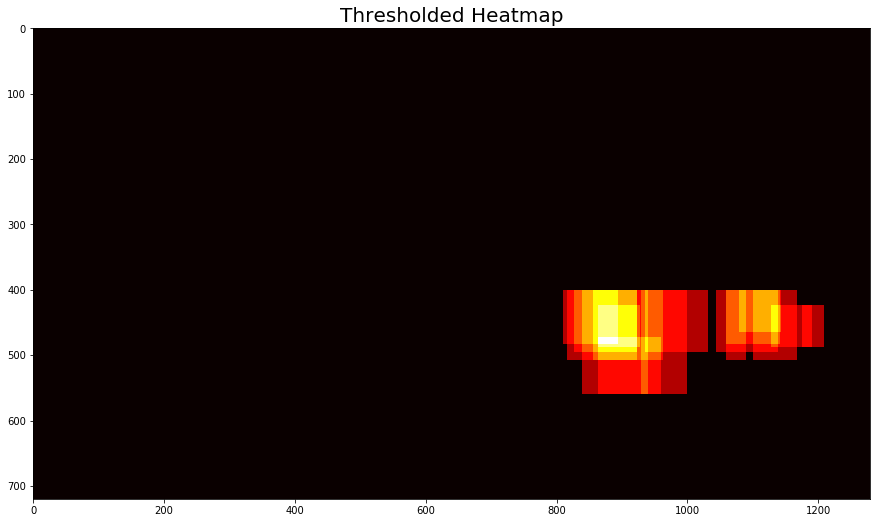

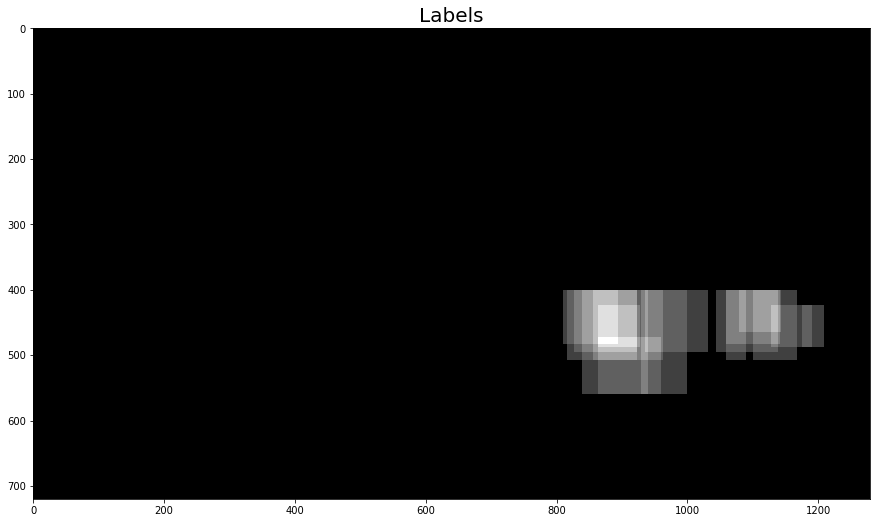

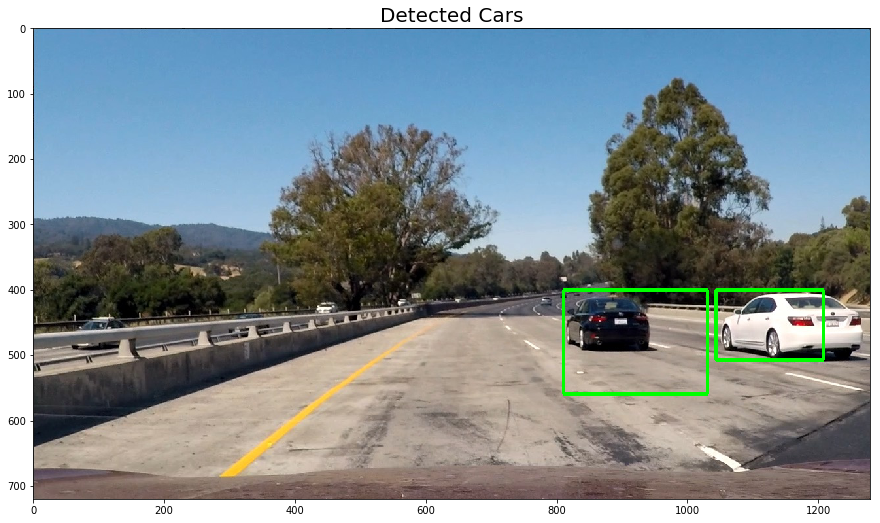

In [13]:
# Heatmap object
heatmap_obj = HeatMap()
# Y-axis dimensions & scales for sliding window search
ydims_scales = [(400,536,1),(400,578,1.3),(400,604,1.5),(400,630,1.7),(400,672,2),(400,680,2.5),(400,664,3),(400,708,3.5)]
# Model's min. prediction confidence below which the detections are discarded
min_prediction_confidence = 0.25
# Min. bounding box dimensions below which the bounding box is not drawn on screen 
min_bbox_w_h = (22,48)
# Debug flag
debug = True
# Detailed debug flag
debug_full = False
# Heatmap overlap threshold (if less than or equal to then the pixels are turned off in the heatmap)
duplicate_threshold = 1
# X-axis value below which the bounding box is not drawn on the screen
x_threshold = 640
# Log file location
log_file = open('./log.txt', 'w')               
# Counter used for naming images (used in visualization & logging)
frame_counter = 0
# Whether to use averaged heatmap of previous 15 frames (if false then only the current frame is considered)
use_avg_heatmap = False

img_path = './test_images/test1.jpg'
img = mpimg.imread(img_path)
frame_name = img_path.split('/')[-1]
out_img = process_frame(img)
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(out_img)
ax.set_title('Detected Cars', fontsize=20)
plt.show()
log_file.close()

---
### Pipeline Run on Multiple Test Images

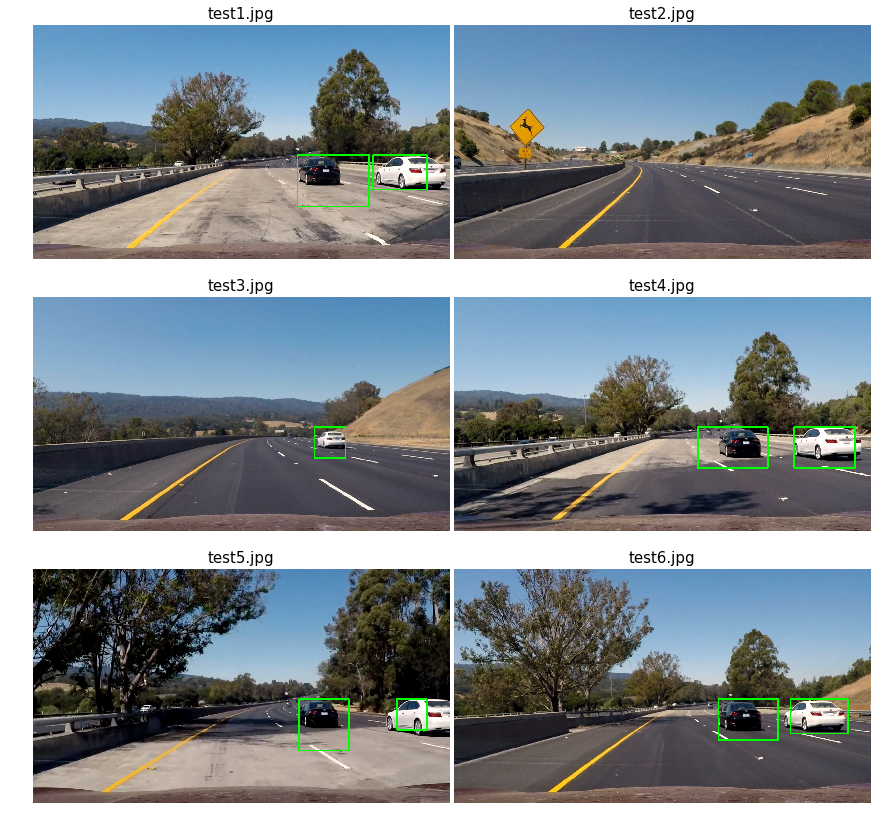

In [14]:
# Heatmap object
heatmap_obj = HeatMap()
# Y-axis dimensions & scales for sliding window search
ydims_scales = [(400,536,1),(400,578,1.3),(400,604,1.5),(400,630,1.7),(400,672,2),(400,680,2.5),(400,664,3),(400,708,3.5)]
# Model's min. prediction confidence below which the detections are discarded
min_prediction_confidence = 0.25
# Min. bounding box dimensions below which the bounding box is not drawn on screen 
min_bbox_w_h = (22,48)
# Debug flag
debug = False
# Detailed debug flag
debug_full = False
# Heatmap overlap threshold (if less than or equal to then the pixels are turned off in the heatmap)
duplicate_threshold = 1
# X-axis value below which the bounding box is not drawn on the screen
x_threshold = 640
# Log file location
log_file = open('./log.txt', 'w')               
# Counter used for naming images (used in visualization & logging)
frame_counter = 0
# Whether to use averaged heatmap of previous 15 frames (if false then only the current frame is considered)
use_avg_heatmap = False

images_path = './test_images/'
test_images_paths = glob.glob(images_path + '*.jpg')
show_out_image = True 
consecutive_frames = False
if(consecutive_frames):
    # Arrange images based on image number so that images are in chronological order.
    # ***This requires frames to be number based e.g. 1.jpg, 2.jpg...***
    image_names_only = list(map(lambda x: int(x.split('\\')[-1].split('.')[0]), test_images_paths))
    test_images_paths_sorted = sorted(image_names_only)
    test_images_paths = list(map(lambda x: images_path + str(x) + '.jpg', test_images_paths_sorted))

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace = .0001, wspace = 0.01)
for i in range(0,len(test_images_paths)):
    frame_name = test_images_paths[i].split('\\')[-1]
    img = mpimg.imread(test_images_paths[i])
    out_img = process_frame(img)
    if (show_out_image):
        plt.subplot(np.ceil(len(test_images_paths)/2), 2, i+1)
        plt.imshow(out_img)
        plt.title(frame_name, fontsize=15)
        plt.axis('off')
plt.show()        

log_file.close()

---
### Video Processing

In [17]:
# Heatmap object
heatmap_obj = HeatMap()
# Y-axis dimensions & scales for sliding window search
ydims_scales = [(400,536,1),(400,578,1.3),(400,604,1.5),(400,630,1.7),(400,672,2),(400,680,2.5),(400,664,3),(400,708,3.5)]
# Model's min. prediction confidence below which the detections are discarded
min_prediction_confidence = 0.25
# Min. bounding box dimensions below which the bounding box is not drawn on screen 
min_bbox_w_h = (22,48)
# Debug flag
debug = False
# Detailed debug flag
debug_full = False
# Heatmap overlap threshold (if less than or equal to then the pixels are turned off in the heatmap)
duplicate_threshold = 1
# X-axis value below which the bounding box is not drawn on the screen
x_threshold = 640
# Log file location
log_file = open('./log.txt', 'w')               
# Counter used for naming images (used in visualization & logging)
frame_counter = 0
# Whether to use averaged heatmap of previous 15 frames (if false then only the current frame is considered)
use_avg_heatmap = True
# Used for logging
frame_name= None

video_output_raw = './project_video_output.mp4'
clip1_raw = VideoFileClip('./project_video.mp4')
video_clip_raw = clip1_raw.fl_image(process_frame) 
%time video_clip_raw.write_videofile(video_output_raw, audio=False)
log_file.close()

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:05:30<00:06,  6.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 2h 5min 33s


In [16]:
HTML("""
<video width="720" height="560" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(video_output_raw))